In [1]:
import glob
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Align import PairwiseAligner

In [2]:
def umi_histogram(fastq_path, max_count):
    conscount_values = []
    
    # Regular expression to find CONSCOUNT field and extract the number
    pattern = re.compile(r"CONSCOUNT=(\d+)")

    # Parse the fastq file
    with open(fastq_path, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            match = pattern.search(record.description)
            if match:
                conscount = int(match.group(1))
                # All values greater than max_count are set to max_count
                conscount = min(conscount, max_count)
                conscount_values.append(conscount)
    
    # Plot the histogram
    # bins should be one more than max_count to include the last bin
    plt.hist(conscount_values, bins=max_count+1, range=(0, max_count+1), edgecolor='black')
    
    fastq_basename = fastq_path.split('/')[-1]
    plt.title(f'Distribution of CONSCOUNT for {fastq_basename}')
    plt.xlabel('CONSCOUNT')
    plt.ylabel('Frequency')
    
    ticks = list(range(0, max_count + 1))
    labels = [str(i) for i in range(0, max_count)] + [f"=>{max_count}"]
    plt.xticks(ticks, labels, rotation=90)
    
    plt.show()


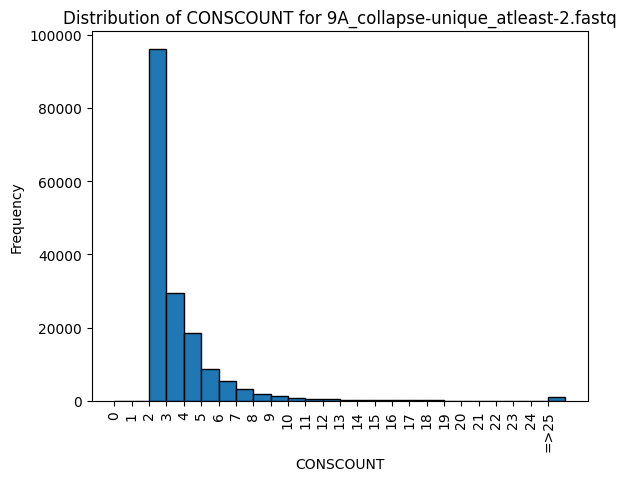

In [3]:
for path in glob.glob("/Users/matsen/re/gcreplay/nextflow/data/passenger/9A/9A_collapse-unique_atleast-2.fastq"):
    umi_histogram(path, 25)


In [4]:
chigy_lc_stop_with_leader_and_intron = "CATGGAGTCACAGACTCAGGTCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAACgtaagtacacttttctcatctttttttatgtgtaagacacaggttttgca".upper()

chigy_lc_stop_trimmed = "GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAAC".upper()

In [5]:
# Get a list of all the files that match the pattern "passenger-blast/*.blast.tsv"
blast_files = glob.glob("passenger-blast/9*.blast.tsv")

# Create an empty list to hold the dataframes
dfs = []

# Loop over the files and read each one into a dataframe
for blast_file in blast_files:
    blast_results = pd.read_csv(blast_file, sep="\t", header=None, names=["query", "subject", "identity", "length", "mismatches", "gap_openings", "q_start", "q_end", "s_start", "s_end", "evalue", "bitscore"])
    # Add a "dataset" column to the dataframe
    blast_results["dataset"] = os.path.basename(blast_file).split('.')[0]

    fasta_file = blast_file.replace(".blast.tsv", ".fasta")
    seq_dict = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))
    # Note that the sequences in the FASTA file are on the reverse strand, so we're doing reverse complement here.
    matching_seqs = {name: str(seq_dict[name].seq.reverse_complement()) for name in blast_results['subject'] if name in seq_dict}
    seq_df = pd.DataFrame(list(matching_seqs.items()), columns=['subject', 'sequence'])
    merged_df = pd.merge(blast_results, seq_df, on='subject', how='inner')
    dfs.append(merged_df)

# Concatenate the dataframes together
blast_df = pd.concat(dfs, ignore_index=True)

blast_df = blast_df[blast_df["length"] == 20]

assert len(blast_df) == len(set(blast_df["subject"]))

# assert that s_start is greater than s_end for every row, meaning that the subject is on the reverse strand
assert np.all(blast_df["s_start"] > blast_df["s_end"])

blast_df = blast_df.drop(columns=['query'])
blast_df

,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence
0,TTCGGTTCAGCTGGGGG|CONSCOUNT=2|PRCONS=TS-shift3...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCANCCNCTCTTCCAGCTCTCAGAG...
1,GCGAGATCACACCTGTA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCG...
2,ATGAGAAAAGTGTATGG|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGT...
3,GAGGTATGCGTAGGCAA|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...
4,CATGGTATTTTAAAGTT|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,AGGAAGTAACGACTAAG|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...
44736,CGGGGCGGACACACGGG|PRCONS=TS-shift4|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGG...
44740,TAGGACGAGTTTGGTGA|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGA...
44741,ACTCGTGGCAACATTAG|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAG...


In [6]:
# Create an aligner object
aligner = PairwiseAligner()

# Set the match score to 1
aligner.match_score = 1
# Set the mismatch score to -1
aligner.mismatch_score = -1

# Set the gap open penalty
aligner.open_gap_score = -5
# Set the gap extend penalty
aligner.extend_gap_score = -2


def oneline_print_alignment(alignment):
    aligned_seq1_str = str(alignment[0])
    aligned_seq2_str = str(alignment[1])

    # Print sequence 1
    print(aligned_seq1_str)
    
    match_str = ''.join('|' if a == b and a != '-' else '.' if a != '-' and b != '-' else ' ' for a, b in zip(aligned_seq1_str, aligned_seq2_str))

    print(match_str)
    
    # Print sequence 2
    print(aligned_seq2_str)


def pretty_print_alignments(alignment_df):
    for index, row in alignment_df.iterrows():
        sequence = row["sequence"]
        alignments = aligner.align(chigy_lc_stop_trimmed, sequence)
        
        print(f"> {row['dataset']} {row['Sequence number']}")
        
        # Get the first alignment (if it exists) and print
        if alignments:
            alignment = alignments[0]
            oneline_print_alignment(alignment)
        else:
            print("No alignment found.\n")
        print()


In [7]:
def summarize_alignment(alignment):
    """
    This function takes in an alignment object where the first sequence is the
    template, and returns a list with
    the sequence of gap lengths in the template and the positions of mutations,
    indexed by non-gap sites in the template sequence.
    We do not consider read gaps as mutations because most of the time they are
    just from sequence length variation.
    
    :param alignment: Biopython alignment object
    :return: Tuple (list of gap lengths in the template, list of mutation positions)
    """
    gap_lengths = []
    mutation_positions = []
    n_positions = []
    mutation_bases = []

    # Extracting aligned sequences from alignment object
    template_seq = str(alignment[0])
    read_seq = str(alignment[1])

    gap_count = 0
    non_gap_index = 0  # This is used to index positions by non-gap sites in the template sequence

    for template_base, read_base in zip(template_seq, read_seq):
        if template_base == '-':
            gap_count += 1
        else:
            if gap_count > 0:
                gap_lengths.append(gap_count)
                gap_count = 0  # Reset the gap count after a gap sequence has ended

            if template_base != read_base and read_base != '-' and read_base != 'N':
                mutation_positions.append(non_gap_index)
                mutation_bases.append(read_base)
            
            if read_base == 'N':
                n_positions.append(non_gap_index)
            
            non_gap_index += 1  # Increment the non-gap index whenever a non-gap character is encountered in the template
    
    # In case the sequence ends with gaps
    if gap_count > 0:
        gap_lengths.append(gap_count)
    
    return gap_lengths, mutation_positions, mutation_bases, n_positions


def test_summarize_alignment():
    """
    original alignment:
    --AAA---AA
    A-C-AAAACN

    after deleting columns with gaps in template:
    AAAAA
    C-ACN

    So we have mutations at positions 0, 3 (site 1 is a gap)
    """
    alignment = ['--AAA---AA', 'A-C-AAAACN']
    
    # Call the function with this manual alignment
    gap_lengths, mutation_positions, mutation_bases, n_positions = summarize_alignment(alignment)

    # Expected outputs
    expected_gap_lengths = [2, 3]
    expected_mutation_positions = [0, 3]
    expected_mutation_bases = ["C", "C"]
    expected_n_positions = [4]
    
    assert gap_lengths == expected_gap_lengths, f"Expected {expected_gap_lengths}, but got {gap_lengths}"
    assert mutation_positions == expected_mutation_positions, f"Expected {expected_mutation_positions}, but got {mutation_positions}"
    assert mutation_bases == expected_mutation_bases, f"Expected {expected_mutation_bases}, but got {mutation_bases}"
    assert n_positions == expected_n_positions, f"Expected {expected_n_positions}, but got {n_positions}"
    
test_summarize_alignment()


In [8]:
def run_alignment(template, sequence):
    alignments = aligner.align(template, sequence)
    assert alignments is not None, "No alignment found."
    return alignments[0]

def perform_alignment_and_summary(row):
    """Note that the mutation_positions are with repsect to the trimmed template
    sequence, whereas the gap_lengths are with respect to the original template
    sequence."""
    sequence = row["sequence"]
    alignment = run_alignment(chigy_lc_stop_with_leader_and_intron, sequence)
    gap_lengths, _, _, _ = summarize_alignment(alignment)
    alignment = run_alignment(chigy_lc_stop_trimmed, sequence)
    _, mutation_positions, mutation_bases, n_positions = summarize_alignment(alignment)
    
    return pd.Series({
        'gap_segment_count': len(gap_lengths),
        'mutation_positions': mutation_positions,
        'mutation_bases': mutation_bases,
        'n_positions': n_positions,
    })

alignment_summary_df = blast_df.apply(perform_alignment_and_summary, axis=1)

# Concatenating the new DataFrame with the original one horizontally
processed_stop_df = pd.concat([blast_df, alignment_summary_df], axis=1)

processed_stop_df["mutation_count"] = processed_stop_df["mutation_positions"].apply(len)
processed_stop_df["n_count"] = processed_stop_df["n_positions"].apply(len)

In [9]:
processed_stop_df["Sequence number"] = processed_stop_df.index

processed_stop_df

,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence,gap_segment_count,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
0,TTCGGTTCAGCTGGGGG|CONSCOUNT=2|PRCONS=TS-shift3...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCANCCNCTCTTCCAGCTCTCAGAG...,1,[],[],[],0,0,0
1,GCGAGATCACACCTGTA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCG...,1,"[4, 43]","[C, G]",[17],2,1,1
2,ATGAGAAAAGTGTATGG|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGT...,1,[],[],[155],0,1,2
3,GAGGTATGCGTAGGCAA|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,1,[],[],[],0,0,3
4,CATGGTATTTTAAAGTT|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1,[122],[A],[47],1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,AGGAAGTAACGACTAAG|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,1,[106],[T],[],1,0,44731
44736,CGGGGCGGACACACGGG|PRCONS=TS-shift4|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGG...,1,[295],[T],[],1,0,44736
44740,TAGGACGAGTTTGGTGA|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGA...,1,[],[],[],0,0,44740
44741,ACTCGTGGCAACATTAG|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAG...,1,[278],[T],[],1,0,44741


In [10]:
pretty_print_alignments(processed_stop_df.head())

> 9A_collapse-unique_atleast-2 0
---------------------------------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                                         |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
GAGCTGCCAGGAGCCTAAGAAGCANCCNCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGTTGTCTGGTGTTGATGGAGACATT

In [11]:
# Group by 'dataset' and count the number of rows in each group
row_counts_by_dataset = processed_stop_df.groupby('dataset').size()

# Print the count of rows for each 'dataset'
print(row_counts_by_dataset)


dataset
9A_collapse-unique_atleast-2    29181
dtype: int64


In [12]:
print(processed_stop_df["mutation_count"].value_counts()[:20].sort_index())


mutation_count
0     5614
1     7337
2     5881
3     3681
4     1947
5     1160
6      617
7      339
8      159
9       59
79      38
80      95
81     128
82     190
83     248
84     255
85     212
86     126
87      75
88      52
Name: count, dtype: int64


In [13]:
# restrict chigy_stop_no_gap_df to exclude rows with more than 40 mutations and exclude dataset 1B.
# chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] <= 40) & (processed_stop_df["dataset"] != "1B_S1_001")].copy()
chigy_believable = processed_stop_df[(processed_stop_df["mutation_count"] <= 40) & (processed_stop_df["n_count"] <= 10)].copy()

chigy_believable

,subject,identity,length,mismatches,gap_openings,q_start,q_end,s_start,s_end,evalue,bitscore,dataset,sequence,gap_segment_count,mutation_positions,mutation_bases,n_positions,mutation_count,n_count,Sequence number
0,TTCGGTTCAGCTGGGGG|CONSCOUNT=2|PRCONS=TS-shift3...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCANCCNCTCTTCCAGCTCTCAGAG...,1,[],[],[],0,0,0
1,GCGAGATCACACCTGTA|CONSCOUNT=2|PRCONS=TS-shift1...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAGACGCGCG...,1,"[4, 43]","[C, G]",[17],2,1,1
2,ATGAGAAAAGTGTATGG|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGT...,1,[],[],[155],0,1,2
3,GAGGTATGCGTAGGCAA|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,1,[],[],[],0,0,3
4,CATGGTATTTTAAAGTT|CONSCOUNT=2|PRCONS=TS-shift2...,100.0,20,0,0,1,20,345,326,0.000326,40.1,9A_collapse-unique_atleast-2,GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGT...,1,[122],[A],[47],1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44731,AGGAAGTAACGACTAAG|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAGAG...,1,[106],[T],[],1,0,44731
44736,CGGGGCGGACACACGGG|PRCONS=TS-shift4|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGG...,1,[295],[T],[],1,0,44736
44740,TAGGACGAGTTTGGTGA|PRCONS=TS-shift1|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGA...,1,[],[],[],0,0,44740
44741,ACTCGTGGCAACATTAG|PRCONS=TS-shift3|SEQORIENT=F...,95.0,20,0,1,1,20,344,326,19.000000,24.3,9A_collapse-unique_atleast-2,GGCAGCTGCCAGGAGCCTAAGAAGCATCCTCTCTTCCAGCTCTCAG...,1,[278],[T],[],1,0,44741


In [14]:
chigy_believable["gap_segment_count"].value_counts()

gap_segment_count
1    26288
2      320
0      283
6       14
5       12
7       10
3        9
4        5
8        3
9        2
Name: count, dtype: int64

In [15]:
# get the last 20 characters of each entry of chigy_believable["sequence"] and store it in a new column called "last_20"
# chigy_believable["last_20"] = chigy_believable["sequence"].str[-20:]
chigy_believable["sequence"].str[-20:].value_counts()


sequence
TCGGGGACTAAGCTAGAAAT    16329
TCGGGGACTANGCTAGAAAT     3663
TCGGGGACTATGCTAGAAAT      757
TCGGGGACTNAGCTAGAAAT      536
TCGGGGACTAAGGTAGAAAT      351
                        ...  
TCGGGGACTGCGGTAGAAAT        1
TCGGGGACTAAGGGAGAAAT        1
TCGGGGACTANCCTAGAATT        1
TCGGGGACTAGGCTAAAAAT        1
CGGGGACTAAACTAGAAATG        1
Name: count, Length: 784, dtype: int64

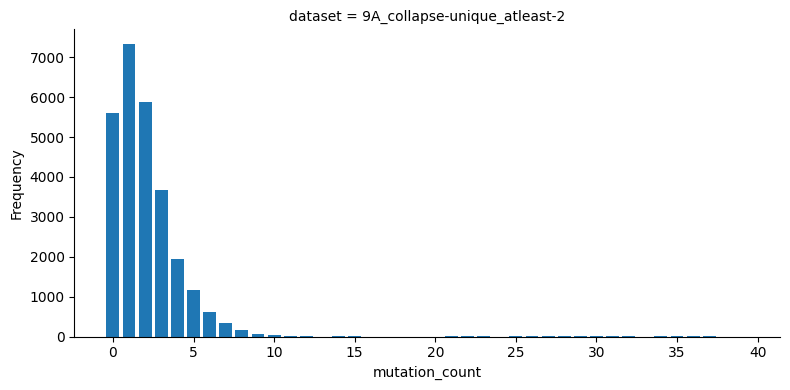

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of unique datasets
num_datasets = chigy_believable['dataset'].nunique()

# Find the maximum mutation count to set the bin edges
max_mutation_count = chigy_believable['mutation_count'].max()
bin_edges = range(0, max_mutation_count + 2)  # +1 for inclusive last bin, +1 for the rightmost edge

# Set up the FacetGrid
g = sns.FacetGrid(chigy_believable, row="dataset", height=4, aspect=2, sharex=True, sharey=False)

# Map a histogram to each subplot
g.map(plt.hist, "mutation_count", bins=bin_edges, align='left', rwidth=0.8)

# Adjust the subplot parameters for better layout
g.fig.subplots_adjust(hspace=0.4)  # adjust the space between plots

# Set y-axis label and make the layout tight
g.set_axis_labels(y_var="Frequency")
plt.tight_layout()

# Show the plots
plt.show()


In [17]:
pretty_print_alignments(chigy_believable[chigy_believable["mutation_count"] == 1].head())

> 9A_collapse-unique_atleast-2 4
-----------------------------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                                   |||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||     
GATCCTCTCTTCCAGCTCTCAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGNGACAGGGTCAGCGTCACCTGCAAG

In [18]:
seq_dict = {
    "full_seq": "GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC",
    "FW1": "GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGC",
    "CDR1": "AAGGCCAGTCAGAATGTGGGTACTAATGTAGCC",
    "FW2": "TGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTAC",
    "CDR2": "TCGGCATCCTACAGGTACAGT",
    "FW3": "GGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGT",
    "CDR3": "CAGCAATATAACAGCTATCCTCTCACG",
    "FW4": "TTCGGCTCGGGGACTAAGCTAGAAATAAAAC"
}

len(seq_dict["FW1"])

69

In [19]:
# ################## Uncomment to filter to 3 reads per UMI ##################
# chigy_believable = chigy_believable[~chigy_believable["subject"].str.contains("CONSCOUNT=2")]
# pattern = re.compile(r"CONSCOUNT=(\d+)")
# matches = chigy_believable["subject"].apply(lambda x: pattern.search(x).group(0))
# matches.value_counts()

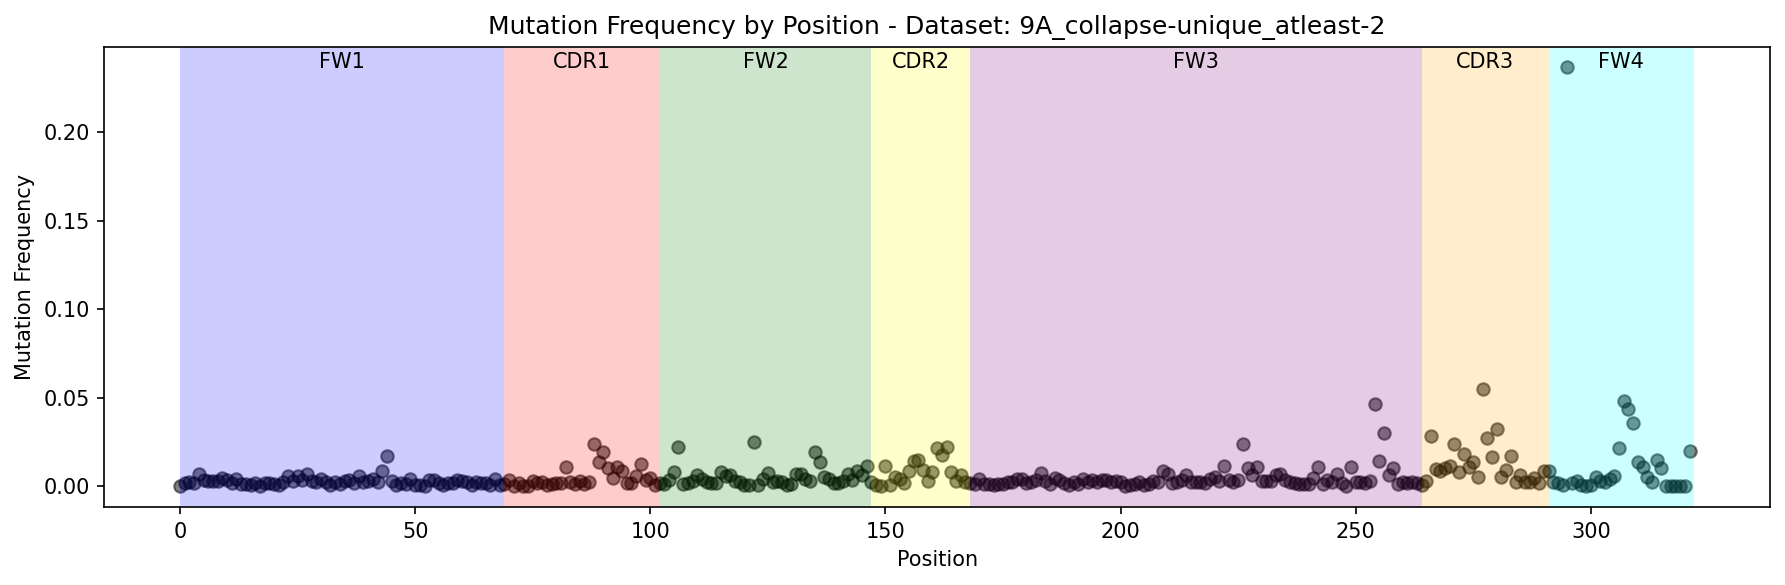

In [20]:
def compute_thing_counts(df, thing_name):
    """
    Compute mutation counts by position from a filtered dataframe.
    """
    max_position = df[thing_name].apply(lambda x: max(x) if x else 0).max()
    mutation_counts_by_position = np.zeros(max_position + 1, dtype=int)
    
    for positions_list in df[thing_name]:
        if positions_list:
            for position in positions_list:
                mutation_counts_by_position[position] += 1
    
    return mutation_counts_by_position

# Calculate the positions where each sequence ends in the full sequence
positions = np.cumsum([len(seq_dict[key]) for key in ["FW1", "CDR1", "FW2", "CDR2", "FW3", "CDR3", "FW4"]])
colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan']
labels = ["FW1", "CDR1", "FW2", "CDR2", "FW3", "CDR3", "FW4"]

# Get the unique datasets
unique_datasets = chigy_believable['dataset'].unique()

# Set up the figure and the array of subplots
fig, axs = plt.subplots(len(unique_datasets), 1, figsize=(12, 4 * len(unique_datasets)), dpi=150)

# Iterate over unique datasets and create a subplot for each one
for index, dataset in enumerate(unique_datasets):
    ax = axs[index] if len(unique_datasets) > 1 else axs
    filtered_df = chigy_believable[chigy_believable['dataset'] == dataset]
    
    mutation_counts_by_position = compute_thing_counts(filtered_df, "mutation_positions")
    
    total_read_count = len(filtered_df)
    mutation_frequency_by_position = mutation_counts_by_position / total_read_count
    
    ax.scatter(range(len(mutation_frequency_by_position)), mutation_frequency_by_position, alpha=0.5, color="black")
    
    start_pos = 0
    for pos, color, label in zip(positions, colors, labels):
        ax.axvspan(start_pos, pos, facecolor=color, alpha=0.2)
        ax.text((start_pos + pos) / 2, ax.get_ylim()[1] * 0.95, label, horizontalalignment='center')
        start_pos = pos + 1e-9  # Add a tiny offset to avoid overlapping
    
    ax.set_title(f'Mutation Frequency by Position - Dataset: {dataset}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Mutation Frequency')

plt.tight_layout()
plt.show()


In [21]:
pretty_print_alignments(chigy_believable.sample(500))

> 9A_collapse-unique_atleast-2 16217
----------------------------------------------------------------GACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCTACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCACCATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCTCTCACGTTCGGCTCGGGGACTAAGCTAGAAATAAAAC
                                                                |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||.||||||||||||||.|||||||||||||||||||||     
GAGAGACGCGCGCCTCCACCATGGAGTCACAGACTCAGGTCTGTGGTTGTCTGGTGTTGATGGAGACATTGTGATGACTCAGTCTCAAAAATTCATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACTAATGTAGCCTGGTATCAACAGAAACCAGGGCA

In [22]:
def compute_mutation_counts_by_base(df, wt_sequence):
    """
    Compute mutation counts by position and by mutated base from a filtered dataframe.
    Entries corresponding to the wild-type base in wt_sequence will have a count of -1.
    Returns a DataFrame with columns 'to_A', 'to_C', 'to_G', 'to_T' and index as position.
    """
    max_position = df['mutation_positions'].apply(lambda x: max(x) if x else 0).max()
    bases = ['A', 'C', 'G', 'T']
    data = {f'to_{base}': [0] * (max_position + 1) for base in bases}

    for index, row in df.iterrows():
        for position, base in zip(row['mutation_positions'], row['mutation_bases']):
            if base in bases:
                data[f'to_{base}'][position] += 1
                
    for position, base in enumerate(wt_sequence): 
        if position <= max_position:
            data[f'to_{base}'][position] = -1

    mutation_counts_df = pd.DataFrame(data)
    return mutation_counts_df

# Test for the function
def test_compute_mutation_counts_by_base():
    wt_sequence = "AGTTC"
    test_df = pd.DataFrame({
        'mutation_positions': [[ 1,   2],   [2,   3],   [3,   4], [  1]],
        'mutation_bases':     [['A', 'C'], ['G', 'A'], ['A', 'G'], ['C']]
    })
    expected_df = pd.DataFrame({
        'to_A': [-1, 1, 0, 2, 0],
        'to_C': [0, 1, 1, 0, -1],
        'to_G': [0, -1, 1, 0, 1],
        'to_T': [0, 0, -1, -1, 0],
    })

    result_df = compute_mutation_counts_by_base(test_df, wt_sequence)
    assert result_df.equals(expected_df), f"Expected:\n{expected_df}\nGot:\n{result_df}"

test_compute_mutation_counts_by_base()

counts_by_base = compute_mutation_counts_by_base(chigy_believable, chigy_lc_stop_trimmed)

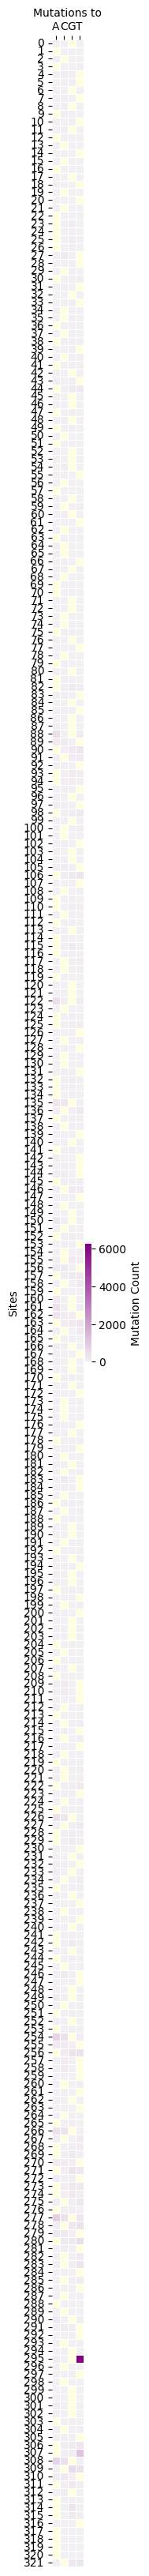

In [23]:
def create_heatmap(data_df):
    # Replace the column names
    data_df = data_df.rename(columns=lambda x: x.split('_')[-1])
    
    # Replace -1 with NaN
    data_df = data_df.replace(-1, np.nan)

    # Setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(len(data_df.columns) * 0.5, len(data_df) * 0.5))
    
    # Define the custom color map
    cmap = sns.light_palette("purple", as_cmap=True)
    cmap.set_bad('#FFFFE0')  # This will set NaN color to a less intense yellow

    # Plotting the heatmap
    sns.heatmap(data_df, cmap=cmap, linewidths=.5, ax=ax, cbar_kws={"label": "Mutation Count"},
                vmin=0, vmax=data_df.max().max(), square=True, yticklabels=True)

    ax.set_ylabel('Sites')
    ax.set_xlabel('Mutations to')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.show()

create_heatmap(counts_by_base)


In [24]:
counts_by_base.iloc[295]

to_A     110
to_C      18
to_G      -1
to_T    6247
Name: 295, dtype: int64

In [25]:
n_series = pd.DataFrame({"count of Ns": compute_thing_counts(chigy_believable, "n_positions")}).sort_values(by="count of Ns", ascending=False)
# set the index name of n_series to be "site"
n_series.index.name = "site"
n_series

,count of Ns
site,
295,9787
307,4766
306,1041
49,353
16,86
...,...
135,0
205,0
138,0


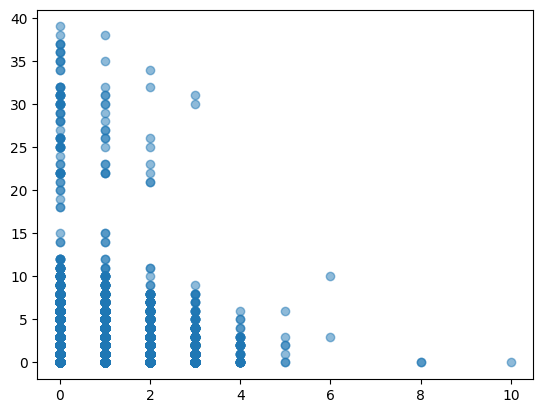

In [26]:
# make a scatter plot of chigy_believable["n_count"] versus chigy_believable["mutation_count"]
plt.scatter(chigy_believable["n_count"], chigy_believable["mutation_count"], alpha=0.5)